## Loops are okay, and sometimes useful, in Julia

In languages like R, Matlab and Python "vectorization" is the preferred programming approach.  That is, work on the whole object (vector, matrix, data frame) whenever possible.

Vectorization is also available and widely used in Julia.  However, it is possible to "de-vectorize" operations without incurring a big penalty.  In fact, loops can sometimes be faster than "whole object" operations.

### Brownian motion

As a simple example, consider approximating a "Wiener process" (sometimes called Brownian motion) as the cumulative sum of a vector of i.i.d. Gaussian variates. 

Begin by loading the packages to be used for graphics and for benchmarking

In [1]:
using BenchmarkTools, DataFrames, Gadfly

A function to simulate `n` random normal variates and take the cumulative sum.  Return a `DataFrame` for plotting. 

In [2]:
wiener(n) = DataFrame(t = 1:n, y = cumsum(randn(n)))  # discrete time Wiener process

wiener (generic function with 1 method)

In [3]:
wiener(10)   # first call causes compilation

,t,y
1,1,1.0308880135347975
2,2,1.2478405650706943
3,3,1.1891172403810266
4,4,1.0074770917455145
5,5,0.8094671562166909
6,6,0.123718852030679
7,7,0.7201134880341118
8,8,1.0753166339684408
9,9,-0.5142832090419573
10,10,0.10546220969989273


In [4]:
@time w = wiener(100_000)

  0.002612 seconds (125 allocations: 2.321 MiB)


,t,y
1,1,-0.31322634074430317
2,2,1.121806801746534
3,3,2.2319377305838497
4,4,2.0009267558204757
5,5,1.7851525538138815
6,6,2.1147552685038287
7,7,2.7578553974191937
8,8,2.7238897914166977
9,9,4.304075740094468
10,10,3.8560241198886605


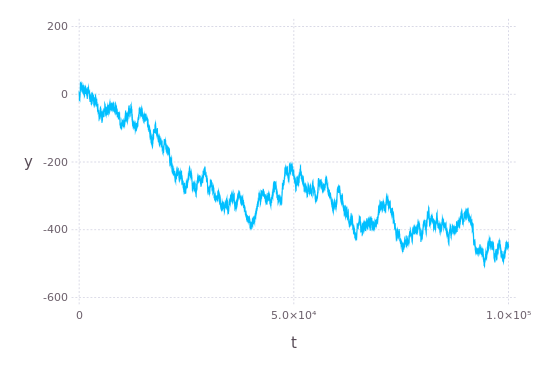

In [5]:
plot(w, x = :t, y = :y, Geom.line)

More reproducible timings are available through the `BenchmarkTools` macro `@btime`

In [6]:
@btime wiener(100_000) seconds=1;

  1.240 ms (40 allocations: 2.31 MiB)


Technically, there should be a value of 0 at time zero.

In [6]:
wiener(n) = DataFrame([0:n, unshift!(cumsum(randn(n)), 0)], [:t, :y])

wiener (generic function with 1 method)

In [7]:
wiener(10)

,t,y
1,0,0.0
2,1,-0.11076549686908026
3,2,0.1509951669774079
4,3,1.4892369232102367
5,4,0.6526235272255754
6,5,-0.4821541253920523
7,6,0.1449207062989542
8,7,0.5299545714847994
9,8,0.8976198217951902
10,9,0.20987381898118657


For reproducibility, we should set the random number generator seed

In [8]:
srand(1234321)
@btime w = wiener(100_000) seconds=1

  1.322 ms (28 allocations: 2.29 MiB)


,t,y
1,0,0.0
2,1,0.05913391112597391
3,2,0.9266241254455814
4,3,1.3750019205781585
5,4,1.3205917685892563
6,5,1.7425948250965049
7,6,2.4684777477729694
8,7,1.5026092680885808
9,8,2.170149972757617
10,9,2.519697526532717


Setting the random number generator seed changes global state.  We can set the state by passing a random number generator to the function.

In [9]:
wiener(rng::AbstractRNG, n) = DataFrame([0:n, unshift!(cumsum(randn(rng, n)), 0)], [:t, :y])    

wiener (generic function with 2 methods)

In [10]:
wiener(MersenneTwister(1234321), 30)

,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.3820412483932496
6,5,-2.343620992160594
7,6,-3.5063006894866757
8,7,-3.526555440358628
9,8,-4.274118082572377
10,9,-2.9501809052569556


The default method, using the global RNG can then be defined in terms of this method.

In [11]:
wiener(n) = wiener(Base.Random.GLOBAL_RNG, n)

wiener (generic function with 2 methods)

In [16]:
methods(wiener)

# 2 methods for generic function "wiener":
wiener(rng::AbstractRNG, n) in Main at In[13]:1
wiener(n) in Main at In[15]:1

In [17]:
srand(1234321)
wiener(10)

,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.3820412483932496
6,5,-2.343620992160594
7,6,-3.5063006894866757
8,7,-3.526555440358628
9,8,-4.274118082572377
10,9,-2.9501809052569556


## Alternative implementations

Unlike R, Matlab, etc., there is no inherent penalty on looping in Julia.

In [12]:
function wiener(rng::AbstractRNG, n)
    s = randn(rng)
    y = zeros(typeof(s), n + 1)
    for i in 1:n
        y[i + 1] = s
        s += randn(rng)
    end
    DataFrame([0:n, y], [:t, :y])
end

wiener (generic function with 2 methods)

In [13]:
wiener(MersenneTwister(1234321), 10)

,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.38204124839325
6,5,-2.3436209921605946
7,6,-3.506300689486676
8,7,-3.5265554403586283
9,8,-4.274118082572377
10,9,-2.950180905256956


In [20]:
@btime w = wiener(MersenneTwister(1234321), 100_000) seconds=1

  783.493 μs (33 allocations: 789.78 KiB)


,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.38204124839325
6,5,-2.3436209921605946
7,6,-3.506300689486676
8,7,-3.5265554403586283
9,8,-4.274118082572377
10,9,-2.950180905256956


We can even use the naive approach of starting with an empty vector and appending to it in a loop.

In [14]:
function wiener(rng::AbstractRNG, n)
    s = randn(rng)
    y = [zero(s)]   # first element
    for i in 1:n
        push!(y, s)
        s += randn(rng)
    end
    DataFrame([0:n, y], [:t, :y])
end

wiener (generic function with 2 methods)

In [15]:
wiener(MersenneTwister(1234321), 10)

,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.38204124839325
6,5,-2.3436209921605946
7,6,-3.506300689486676
8,7,-3.5265554403586283
9,8,-4.274118082572377
10,9,-2.950180905256956


In [23]:
@btime w = wiener(MersenneTwister(1234321), 100_000) seconds=1;

  1.337 ms (49 allocations: 2.01 MiB)


This is slightly slower but not drastically slower than pre-allocating.  If we know the approximate size of the result, we can give a hint.

In [24]:
function wiener(rng::AbstractRNG, n)
    s = randn(rng)
    y = sizehint!([zero(s)], n+1)
    for i in 1:n
        push!(y, s)
        s += randn(rng)
    end
    DataFrame([0:n, y], [:t, :y])
end

wiener (generic function with 2 methods)

In [25]:
wiener(MersenneTwister(1234321), 10)

,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.38204124839325
6,5,-2.3436209921605946
7,6,-3.506300689486676
8,7,-3.5265554403586283
9,8,-4.274118082572377
10,9,-2.950180905256956


In [26]:
@btime wiener(MersenneTwister(1234321), 100_000)  seconds=1;

  1.199 ms (33 allocations: 1.01 MiB)


### Cases where the result size is not known

In the case of a simple simulation we know the size of the result in advance.  In some cases we don't know this.

Consider the positions of the *zero crossings* of the sequence.

In [27]:
function zerocross(rng::AbstractRNG, n)
    zcrossings = [0]
    s = randn(rng)
    for i in 1:n
        ss = s + randn(rng)
        if (s * ss) < 0
            push!(zcrossings, i)
        end
        s = ss
    end
    zcrossings
end

zerocross (generic function with 1 method)

In [28]:
zerocross(MersenneTwister(1234321), 100_000)

336-element Array{Int64,1}:
     0
    53
    78
  1507
  1515
  1569
  1570
  1587
  1588
  4964
  4965
  4967
  4970
     ⋮
 99661
 99663
 99664
 99671
 99672
 99673
 99674
 99677
 99705
 99708
 99718
 99722

In [29]:
@btime zerocross(MersenneTwister(1234321), 10_000_000) seconds=1

  68.251 ms (21 allocations: 71.22 KiB)


2932-element Array{Int64,1}:
       0
      53
      78
    1507
    1515
    1569
    1570
    1587
    1588
    4964
    4965
    4967
    4970
       ⋮
 8464100
 8464537
 8464538
 8464579
 8464580
 8464582
 8464592
 8464596
 8464603
 8464606
 8464607
 8466987